0.7509363295880149 0.3202614379084967 0.6282051282051282 0.42424242424242425
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       456
           1       0.32      0.63      0.42        78

    accuracy                           0.75       534
   macro avg       0.62      0.70      0.63       534
weighted avg       0.84      0.75      0.78       534



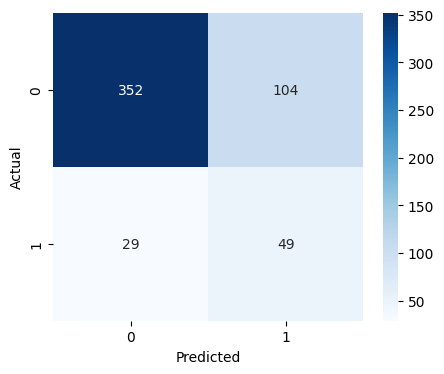

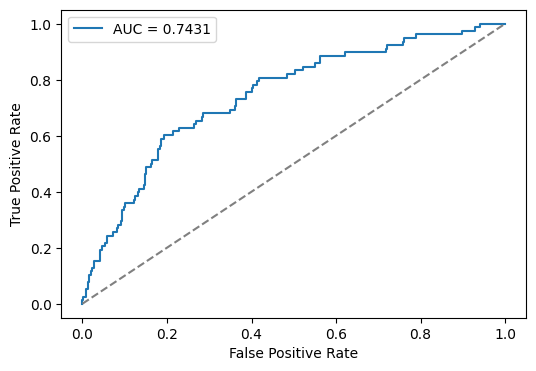

                   Feature  Coefficient  Odds_Ratio
66  International plan_Yes     2.784026   16.184040
58                State_TX     1.300976    3.672880
41                State_MT     1.204324    3.334503
40                State_MS     1.117700    3.057813
55                State_SC     0.905795    2.473898
15  Customer service calls     0.890096    2.435364
46                State_NJ     0.858266    2.359067
62                State_WA     0.788787    2.200726
50                State_OH     0.776660    2.174198
36                State_ME     0.769837    2.159414
37                State_MI     0.688942    1.991606
49                State_NY     0.639385    1.895314
22                State_DC     0.448106    1.565345
53                State_PA     0.431875    1.540143
34                State_MA     0.422632    1.525972
3        Total day minutes     0.384189    1.468423
5         Total day charge     0.380823    1.463489
38                State_MN     0.357617    1.429917
21          

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

df = pd.read_csv("churn-bigml-80.csv")
df["Churn"] = df["Churn"].astype(int)

cat_cols = ["State", "International plan", "Voice mail plan"]
cat_cols = [c for c in cat_cols if c in df.columns]
numeric_cols = [c for c in df.columns if c not in cat_cols + ["Churn"]]

df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df_enc.drop(columns=["Churn"])
y = df_enc["Churn"]

num_cols_to_scale = [c for c in numeric_cols if c in X.columns]

scaler = StandardScaler()
if num_cols_to_scale:
    X[num_cols_to_scale] = scaler.fit_transform(X[num_cols_to_scale])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(acc, prec, rec, f1)
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

feat_names = X.columns
coefs = model.coef_[0]

coef_df = pd.DataFrame({
    "Feature": feat_names,
    "Coefficient": coefs,
    "Odds_Ratio": np.exp(coefs)
}).sort_values(by="Odds_Ratio", ascending=False)

print(coef_df.head(20))


In [ ]:
import pandas as pd
import numpy as np
import joblib

def predict_customer(customer, model, scaler, feature_columns, num_cols_to_scale, threshold=0.5):
    df_new = pd.DataFrame([customer])
    df_new_enc = pd.get_dummies(df_new)
    df_new_reindexed = df_new_enc.reindex(columns=feature_columns, fill_value=0)
    if num_cols_to_scale:
        df_new_reindexed[num_cols_to_scale] = scaler.transform(df_new_reindexed[num_cols_to_scale])
    prob = model.predict_proba(df_new_reindexed)[:, 1][0]
    pred = int(prob >= threshold)
    return {"probability": float(prob), "prediction": pred}

feature_columns = X.columns
customer_example = {
    "State": "OH",
    "Account length": 128,
    "Area code": 415,
    "International plan": "No",
    "Voice mail plan": "Yes",
    "Number vmail messages": 25,
    "Total day minutes": 265.1,
    "Total day calls": 110,
    "Total day charge": 45.07,
    "Total eve minutes": 197.4,
    "Total eve calls": 99,
    "Total eve charge": 16.78,
    "Total night minutes": 244.7,
    "Total night calls": 91,
    "Total night charge": 11.01,
    "Total intl minutes": 10.0,
    "Total intl calls": 3,
    "Total intl charge": 2.70,
    "Customer service calls": 1
}

result = predict_customer(
    customer_example,
    model=model,
    scaler=scaler,
    feature_columns=feature_columns,
    num_cols_to_scale=num_cols_to_scale,
    threshold=0.5
)

print("Churn probability:", result["probability"])
print("Predicted churn (1=yes,0=no):", result["prediction"])

def predict_batch(df_customers, model, scaler, feature_columns, num_cols_to_scale, threshold=0.5):
    df_enc = pd.get_dummies(df_customers)
    df_reindexed = df_enc.reindex(columns=feature_columns, fill_value=0)
    if num_cols_to_scale:
        df_reindexed[num_cols_to_scale] = scaler.transform(df_reindexed[num_cols_to_scale])
    probs = model.predict_proba(df_reindexed)[:, 1]
    preds = (probs >= threshold).astype(int)
    return pd.DataFrame({"probability": probs, "prediction": preds}, index=df_customers.index)


joblib.dump(model, "logreg_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(list(feature_columns), "feature_columns.joblib")
joblib.dump(num_cols_to_scale, "num_cols_to_scale.joblib")

# To load and use later:
# model = joblib.load("logreg_model.joblib")
# scaler = joblib.load("scaler.joblib")
# feature_columns = joblib.load("feature_columns.joblib")
# num_cols_to_scale = joblib.load("num_cols_to_scale.joblib")


Churn probability: 0.5626865510003615
Predicted churn (1=yes,0=no): 1


['num_cols_to_scale.joblib']